# 자연어와 단어의 분산 표현

자연어(natural language) : 한국어, 영어 등 우리가 평소에 쓰는 말  
자연어처리(NLP) : 우리의 말을 컴퓨터에게 이해시키기 위한 기술(분야)
- 자연어를 컴퓨터에게 이해 시키는데에는 '단어의 의미'를 이해시키는 것이 중요

## 단어의 의미
단어의 의미를 잘 파악하여 표현하는 방법들
- 시소러스를 활용한 기법
- 통계 기반 기법
- 추론 기반 기법(word2vec)

## 시소러스(thesaurus) - 유의어 사전
- '상위와 하위', '전체와 부분' 등 세세한 관계까지 정의  
<br/> <img src="../figs/fig%202-1.png" style="width: 300px;"> <br/> 
- 아래 단어 네트워크를 이용하여 컴퓨터에게 단어 사이의 관계를 가르침
<br/> <img src="../figs/fig%202-2.png" style="width: 300px;">


### WordNet
- 1985년 프린스턴 대학교에서 구축하기 시작한 전통있는 시소러스

### 시소러스의 문제점
- 시대 변화에 대응하기 어려움
- 수작업을 하는데 드는 비용이 큼
- 단어 사이의 미묘한 차이를 표현할 수 없음

## 통계 기반 기법

- 말뭉치(corpus) : 자연어 처리 연구나 어플리케이션을 염두에 두고 수집된 대량의 텍스트 데이터

In [1]:
# 파이썬으로 말뭉치 전처리하기
text = 'Hi my name is Dongyoung, what is your name?'

In [2]:
text = text.lower() # 소문자로
text = text.replace(',', ' ,')
text = text.replace('?', ' ?')
text

'hi my name is dongyoung , what is your name ?'

- 정규표현식(regular expression) 호출 시 더 효율적으로 분할 가능

In [3]:
words = text.split(' ')
# words = re.split('(\W+)?'.text)
words

['hi', 'my', 'name', 'is', 'dongyoung', ',', 'what', 'is', 'your', 'name', '?']

- 각 단어에 id 부여

In [4]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [5]:
word_to_id

{'hi': 0,
 'my': 1,
 'name': 2,
 'is': 3,
 'dongyoung': 4,
 ',': 5,
 'what': 6,
 'your': 7,
 '?': 8}

In [6]:
id_to_word

{0: 'hi',
 1: 'my',
 2: 'name',
 3: 'is',
 4: 'dongyoung',
 5: ',',
 6: 'what',
 7: 'your',
 8: '?'}

In [7]:
import numpy as np

corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 5, 6, 3, 7, 2, 8])

In [8]:
def preprocess(text):
    text = text.lower()
    symbols = [',', '.', '?', '!'] 
    for s in symbols:
        text = text.replace(s, ' ' + s + ' ')
    words = text.split(' ')
    words = [i for i in words if i != '']
    
    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [9]:
text = 'You s!ay G.oo??dBye, I say hello!'
corpus, word_to_id, id_to_word = preprocess(text)

In [10]:
corpus, word_to_id

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  8,  9, 10, 11, 12,  2]),
 {'you': 0,
  's': 1,
  '!': 2,
  'ay': 3,
  'g': 4,
  '.': 5,
  'oo': 6,
  '?': 7,
  'dbye': 8,
  ',': 9,
  'i': 10,
  'say': 11,
  'hello': 12})

### 분산 표현(distributional representation)
- '색'을 (R, G, B)의 벡터로 표현하듯이 '단어'도 벡터로 표현하려는 시도



### 분포 가설(distributional hypothesis)
- '단어의 의미는 주변 단어에 의해 형성된다'는 가설
- 단어가 사용된 맥락(context)이 단어의 의미를 형성한다는 것
- 윈도우 크기(window size) : 맥락에 주변 단어를 몇개나 포함할지
<br/> <img src="../figs/fig%202-3.png" style="width: 500px;"><br/><br/><br/>

### 동시발생 행렬
- 통계 기반 기법 : 주변에 어떤 단어가 몇번씩 사용되는지 세어서 집계하는 방법

In [11]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


- 동시발생 행렬(co-occurence matrix) : 동시발생하는 단어를 표에 정리한 것
<br/> <img src="../figs/fig%202-7.png" style="width: 400px;" ><br/><br/><br/>

In [12]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            idx_left = idx - i
            idx_right = idx + i
            
            if idx_left >= 0:
                left_word_id = corpus[idx_left]
                co_matrix[word_id, left_word_id] += 1
            
            if idx_right < corpus_size:
                right_word_id = corpus[idx_right]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

In [15]:
create_co_matrix(corpus, vocab_size=len(id_to_word))

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

### 벡터간 유사도
- cosine similarity를 주로 사용
<br/> <img src="../figs/e%202-1.png" style="width: 500px;"><br/><br/><br/>

In [16]:
def cos_similarity(x, y, eps=1e-8):
    '''
    cos similarity 계산
    분모에 eps를 넣어서 0으로 나누기 방지
    '''
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)

In [17]:
text = 'You say goodbye and I say hello!'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(f'you와 i의 유사도 : {cos_similarity(c0, c1)}')

you와 i의 유사도 : 0.7071067758832467


### 유사 단어의 랭킹
- 특정 단어에 대해 비슷한 단어를 유사도 순으로 출력하는 함수 정의

In [18]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''
    query : 검색어(단어)
    query와 유사한 단어를 상위 top(=5)개 만큼 출력하는 함수
    '''
    if query not in word_to_id:
        print(f'{query}를 찾을 수 없습니다.')
        return
    
    print('\n[query]: ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # Cosine similarity
    vacab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    #유사도 순으로 출력
    cnt = 0
    for i in (-1*similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(f'{id_to_word[i]}: {round(similarity[i],4)}')
        
        cnt += 1
        if cnt >= top:
            return
    

In [19]:
text = 'English is a West Germanic language of the Indo-European language family, originally spoken by the inhabitants of early medieval England. It is named after the Angles, one of the ancient Germanic peoples that migrated to the area of Great Britain that later took their name, England. Both names derive from Anglia, a peninsula on the Baltic Sea which is not to be confused with East Anglia, the Eastern part of England which comprises the counties of Norfolk, Suffolk and Essex.'
print(text)
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size, window_size=4)
most_similar('english', word_to_id, id_to_word, C, top=5)

English is a West Germanic language of the Indo-European language family, originally spoken by the inhabitants of early medieval England. It is named after the Angles, one of the ancient Germanic peoples that migrated to the area of Great Britain that later took their name, England. Both names derive from Anglia, a peninsula on the Baltic Sea which is not to be confused with East Anglia, the Eastern part of England which comprises the counties of Norfolk, Suffolk and Essex.

[query]: english
west: 0.5669
language: 0.4082
a: 0.4009
baltic: 0.3536
germanic: 0.3354


### 상호 정보량(Mutual Information)
- 점별 상호 정보량(Pointwise Mutual Information)
-  'the'와 같이 관련성이 적지만 동시에 자주 발생하는 경우를 해결하기 위함
<br/> <img src = "../figs/e%202-3.png" > <br/>
- 이 때 두 단어의 동시 발생횟수가 0번이면 $log_{2}0 = - \infty$ 이 되므로 양의 상호정보량(Positive PMI) 사용
<br/> <img src = "../figs/e%202-6.png" > <br/>
- 어휘 수에 따라 차원수가 커지는 문제가 있음.

In [20]:
def ppmi(C, verbose=False, eps=1e-8):
    '''
    Positive Pointwise Mutual Information
    C : co-occurence matrix
    verbose : 진행상황 출력 여부
    eps : 0으로 나누기 방지
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose: 
                cnt += 1
                if cnt % (total//10) == 0:
                    print(f'{100*cnt/total}% 완료')
    return M

In [21]:
text = 'English is a West Germanic language of the Indo-European language family, originally spoken by the inhabitants of early medieval England. It is named after the Angles, one of the ancient Germanic peoples that migrated to the area of Great Britain that later took their name, England. Both names derive from Anglia, a peninsula on the Baltic Sea which is not to be confused with East Anglia, the Eastern part of England which comprises the counties of Norfolk, Suffolk and Essex.'
print(text)
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)
np.set_printoptions(precision=3)
print(C)
print('-'*50)
print('PPMI')
print(W)

English is a West Germanic language of the Indo-European language family, originally spoken by the inhabitants of early medieval England. It is named after the Angles, one of the ancient Germanic peoples that migrated to the area of Great Britain that later took their name, England. Both names derive from Anglia, a peninsula on the Baltic Sea which is not to be confused with East Anglia, the Eastern part of England which comprises the counties of Norfolk, Suffolk and Essex.
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]
--------------------------------------------------
PPMI
[[0.    4.874 0.    ... 0.    0.    0.   ]
 [4.874 0.    2.874 ... 0.    0.    0.   ]
 [0.    2.874 0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    5.459 0.   ]
 [0.    0.    0.    ... 5.459 0.    5.459]
 [0.    0.    0.    ... 0.    5.459 0.   ]]


### 차원 감소(dimensionality reduction)
- 벡터의 차원을 줄이는 방법.  
  중요도가 낮은 (대부분 0이라거나) 원소가 많아서 차원이 커지는 문제를 해결
- SVD 사용

In [22]:
U, S, V = np.linalg.svd(W)

In [23]:
print(U[0])

[ 0.088  0.055 -0.184 -0.117 -0.097 -0.134  0.141  0.024 -0.129  0.023
  0.048  0.06   0.045  0.077  0.02   0.032 -0.014  0.07   0.024 -0.129
 -0.04   0.037 -0.092 -0.055 -0.101 -0.118  0.09   0.09   0.043 -0.035
  0.083 -0.098  0.054 -0.001  0.101  0.162 -0.1    0.062  0.19  -0.098
 -0.19   0.056 -0.26   0.024 -0.058  0.259 -0.025  0.317  0.069  0.083
 -0.064 -0.276 -0.112 -0.102 -0.028  0.031 -0.08  -0.492 -0.146]


findfont: Font family ['D2Coding ligature'] not found. Falling back to DejaVu Sans.


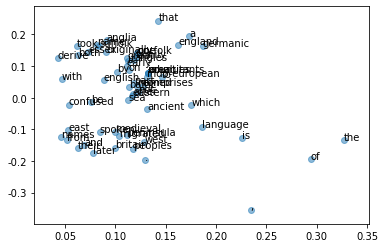

In [24]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show();

### PTB(Penn Treebank) dataset

In [30]:
cd NLP_study/NLP-from-scratch

C:\Users\dongyoung\NLP_study\NLP-from-scratch


In [31]:
from data import ptb

In [32]:
corpus, word_to_id, id_to_word = ptb.load_data('train')

print(f'말뭉치 길이 : {len(corpus)}')
print(f'corpus[:30]: {corpus[:30]}')
print()
print(f'word_to_id[\'car\']:{word_to_id["car"]}')
print(f'word_to_id[\'happy\']:{word_to_id["happy"]}')
print(f'word_to_id[\'lexus\']:{word_to_id["lexus"]}')

말뭉치 길이 : 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

word_to_id['car']:3856
word_to_id['happy']:4428
word_to_id['lexus']:7426


In [33]:
# 빠른 svd 연산

window_size = 2
wordvec_size = 100

vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산')
W = ppmi(C, verbose=True)

print('SVD')
try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    U, S, V = np.linalg.svd(W)
    
word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산


D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in long_scalars
  app.launch_new_instance()
D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log2
  app.launch_new_instance()


10.0% 완료
20.0% 완료
30.0% 완료
40.0% 완료
50.0% 완료
60.0% 완료
70.0% 완료
80.0% 완료
90.0% 완료
100.0% 완료
SVD

[query]: you
i: 0.6981
we: 0.635
do: 0.5512
'll: 0.5475
've: 0.5344

[query]: year
month: 0.6668
next: 0.6132
quarter: 0.61
last: 0.6068
earlier: 0.5765

[query]: car
luxury: 0.6749
truck: 0.6331
auto: 0.61
domestic: 0.5384
corsica: 0.5336

[query]: toyota
motor: 0.7411
nissan: 0.6706
lexus: 0.6219
honda: 0.6187
motors: 0.605
